In [24]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
import seaborn as sns

tf.get_logger().setLevel('ERROR')
import numpy as np
import statistics
# roughly following the docs here: https://www.tensorflow.org/text/tutorials/classify_text_with_bert
%matplotlib inline
%run -i ./Model_Eval.ipynb

In [13]:
one_star_reviews = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv")

In [14]:
one_star_reviews = pd.read_csv("../Training_Data/one_star_reviews_balanced.csv")

# temporary:
one_star_reviews = one_star_reviews.sample(frac = 1) # temporarily just to see model performance

x, y = one_star_reviews['full_text'].values, one_star_reviews['reviewer_avg_rating'].values
X_train, X_test, Y_train, Y_test = train_test_split(x,y, test_size=0.33, random_state=42)

In [34]:
lengths = [len(text.split(' ')) for text in one_star_reviews['full_text']]

In [35]:
lengths = [length for length in lengths if length < 200]

In [42]:
lengths.count(4)

21147

Text(0.5, 1.0, 'Review length distribution')

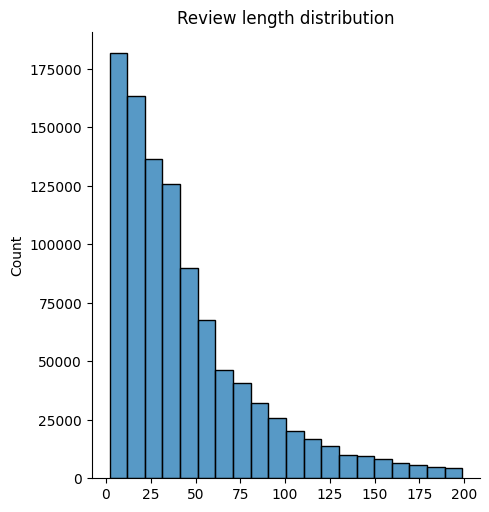

In [38]:
sns.displot(lengths, bins=20)
plt.title('Review length distribution')

In [5]:
bert_model_name = 'bert_multi_cased_L-12_H-768_A-12'
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3'

In [6]:
bert_model = hub.KerasLayer(tfhub_handle_encoder);

2023-02-10 18:41:10.699787: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 18:41:10.725857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 18:41:10.726225: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-02-10 18:41:10.726830: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them i

In [10]:
seq_length = 60

def build_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    # process for bert
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input, arguments=dict(seq_length=seq_length))
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder') # FREEZE for now
    outputs = encoder(encoder_inputs)
    
    sequence_output = outputs['sequence_output']
    
    # Build convolutional layers
    conv_layers_for_all_kernel_sizes = []
    kernel_sizes = [2,3,4] # phrase lengths
    num_filters = [15,20] # should capture the size of most sentences
    
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(sequence_output)
        pooling_layer = keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(pooling_layer)
        
    conv_output = keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)
    
    # Pass the convolutional layers output through dense NN
    net = keras.layers.Dense(150, activation='relu')(conv_output)
    net = keras.layers.Dense(150, activation='relu')(net)
    
    regression = keras.layers.Dense(1, activation='linear', name='prediction_layer')(net)
    
    cnn_model = keras.Model(inputs=text_input, outputs=regression)
    
    cnn_model.compile(optimizer='adam', loss='mean_squared_error')
    
    return cnn_model

In [11]:
cnn_model = build_model()

TypeError: in user code:


    TypeError: tf__call() got an unexpected keyword argument 'arguments'


In [8]:
# look at variance of training set
statistics.variance(Y_train)

1.1156525979797927

In [9]:
history = cnn_model.fit(
    X_train,
    Y_train,
    batch_size=50,
    validation_data=(X_test, Y_test),
    epochs=4
)

Epoch 1/4


2023-02-09 01:54:28.925346: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-02-09 01:54:29.977338: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-02-09 01:54:30.688082: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-02-09 01:54:30.720091: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2023-02-09 01:54:30.720155: W tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.20GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be p

14021/14021 [==============================] - 11773s 839ms/step - loss: 1.0991 - val_loss: 1.0751
Epoch 2/4
14021/14021 [==============================] - 12096s 863ms/step - loss: 1.0760 - val_loss: 1.0703
Epoch 3/4
11529/14021 [=======================>......] - ETA: 25:41 - loss: 1.0646

KeyboardInterrupt: 

In [ ]:
plot_loss(history)

In [ ]:
val_loss = history.history['val_loss'][-1]
train_loss = history.history['loss'][-1]

In [ ]:
# calculalte R2 scores

overall_variance = statistics.variance(Y_train)

train_r2 = (overall_variance - train_loss) / overall_variance
val_r2 = (overall_variance - val_loss) / overall_variance

Training loss curves indicates that this could be improved with more epochs, but it's definitely looking better than the pooled version

In [ ]:
print(f'train r2: {train_r2:.5f}')

In [ ]:
print(f'val r2: {val_r2:.5f}')

In [ ]:
history.history